### Importing Libraries

In [1]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [268]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Delta Hedge Class

In [527]:
class DataInfo:
    def __init__(self, ticker: str):
        self.stock = pd.read_csv(f'{ticker}.csv', index_col="Date").squeeze("columns")
        self.log_returns = np.diff(np.log(self.stock))
        self.r = self.log_returns.mean() * 252
        self.sigma = self.log_returns.std() * np.sqrt(252)
        self.s0 = self.stock.iloc[-1]
        self.init_price = self.stock.iloc[0]
        
class DeltaHedge:
    def __init__(self, s0: float, r: float, sigma: float, K: float, T: float, dt: float, n: float=10000, seed: int=1):
        self.s0 = s0
        self.K = K
        self.r = r
        self.T = T
        self.dt = dt
        self.n = n
        self.sigma = sigma
        np.random.seed(seed)

    @staticmethod
    def d1(spot_price: float, K: float, r: float, T: float, sigma: float):
        numerator = np.log(spot_price/K) + (r + sigma**2 / 2)*T
        denominator = sigma * np.sqrt(T)
        return np.divide(numerator, denominator)
      
    @staticmethod
    def delta(spot_price, K: float, r: float, T: float, sigma):
        return norm.cdf(DeltaHedge.d1(spot_price, K, r, T, sigma))
    
    @staticmethod
    def sigma_hat(sigma, rehedge, TX):
        return sigma * np.sqrt(1 + np.sqrt(2/np.pi) * 2 * TX / (sigma * np.sqrt(1/np.array(rehedge))))
    
    def black_sholes(self, K: float, r: float, sigma):
        d1 = DeltaHedge.d1(np.array([[self.s0]]), K, r, self.T, sigma)
        
        d2 = d1 - sigma*np.sqrt(self.T)
        return (norm.cdf(d1) * self.s0 - norm.cdf(d2)* K *np.exp(-r*self.T))[0][0]
        
    def expanded_gbm(self):
        dt = self.dt
        steps = int(round(self.T/dt, 1))
        price = np.ones(self.n)*np.log(self.s0)
        exp = ((self.r - self.sigma**2/2) * 
               self.dt + self.sigma * 
               np.random.normal(0,1, size=(self.n, steps)) * 
               np.sqrt(dt))
        price = np.c_[price, exp].cumsum(axis=1)
        return price
    
    
#delta will be 1 when very in the money
#and will be 0 when out of the money

def simulate(n, r, rehedge, dh, TX = 0):
    def sim(rh):
        sigma = dh.sigma
        
        interest_time = np.linspace(dh.T, 0, rh)
        interest = np.exp(interest_time * r)

        prices = np.exp(dh.expanded_gbm())
        hedged_prices = prices[:, np.linspace(0, dh.T * 365, rh, dtype=int)]

        delta_hedge_time_frame = np.linspace(dh.T, 0.000001, rh)
        delta = DeltaHedge.delta(hedged_prices, dh.K, r, delta_hedge_time_frame, sigma)
        delta_purchases = np.diff(delta, prepend=np.zeros((n,1)))

        # ITM is 1 * strike and OTM is 0 * strike
        stocks_owned_at_end = delta_purchases.sum(axis=1)
        terminal_delta_price = stocks_owned_at_end * prices[:, -1]
        
        delta_purchases_total_value = delta_purchases * hedged_prices 
        delta_purchases_total_value[:, 1:-1] -= TX * np.abs(delta_purchases_total_value[:, 1:-1])
        delta_purchases_total_value = delta_purchases_total_value @ interest

        option_payoff = np.maximum(prices[:, -1] - dh.K, 0)
        portfolio_val = terminal_delta_price - delta_purchases_total_value - option_payoff
        portfolio_val_discounted = portfolio_val * np.exp(-dh.T * r)
        return dh.black_sholes(dh.K, r, sigma) + portfolio_val_discounted
    
    data = np.array([sim(hedge) for hedge in rehedge]) if isinstance(rehedge, list) else sim(rehedge)
    results = stats(data,n)
    return pd.DataFrame(results, index=rehedge), data
    
        
def stats(error, n):
    data = {}
    data['mean'] = np.abs(error.mean(axis=1))
    data['mean_absolute'] = np.abs(error).mean(axis=1)
    
    data['standard_deviation'] =(error).std(axis=1)
    data['standard_error'] = data['standard_deviation'] / np.sqrt(n)
    return data

def plot_stats(hedges, stats, file_name ,mu=0, tx=0):
    import matplotlib as mpl
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams["font.size"] = 18
    plt.style.use('seaborn')
    plt.rcParams["figure.figsize"] = (12,8)
    plt.rcParams['figure.dpi'] = 300
    plt.subplot(2,2,1)
    
    plt.plot(1/hedges,stats['mean'], label='mean', marker='o')
    plt.plot(1/hedges,stats['standard_error'], label='std. error', color='red', linestyle='--', marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Mean Error, mu={mu}, tx={tx}', fontsize=10)
    plt.xlabel('$\Delta t$', fontsize=10)
    plt.ylabel('Error', fontsize=10)
    plt.legend(loc="upper left")

    plt.subplot(2,2,2)
    plt.plot(1/hedges,stats['mean_absolute'], label='MAE', marker='o')
    plt.plot(1/hedges,stats['standard_deviation'], label='std. dev', color='red', linestyle='--', marker='o')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Mean Absolute Error, mu={mu}, tx={tx}', fontsize=10)
    plt.xlabel('$\Delta t$', fontsize=10)
    plt.ylabel('Error', fontsize=10)
    plt.legend(loc="upper left")
    
    plt.tight_layout()
    plt.savefig(f'{file_name}.eps', bbox_inches='tight', pad_inches=0)
    plt.show()

In [528]:
n = 100000
T = 1

S0 = 4225
K = 4225
r = 0.005
sigma = 0.18

dh = DeltaHedge(S0, r, sigma, K, T, 1/365, n=n, seed=123)
prices = np.exp(dh.expanded_gbm())

## 1 A. Varying hedge periods

### Simulating Delta Hedge

In [416]:
hedge_periods = [0,1,4,12,52,365]
res = simulate(n, r, hedge_periods, dh)

In [417]:
res

mean  mean_absolute  standard_deviation  standard_error
0    2.928141     380.139610          504.951023        1.596795
1    0.358113     181.479375          227.994974        0.720983
4    0.002800     108.770324          140.382802        0.443929
12   0.022084      57.756108           76.153806        0.240819
52   0.016773      27.394315           36.622535        0.115811
365  0.008388      10.487060           14.261835        0.045100

### Prices Plot

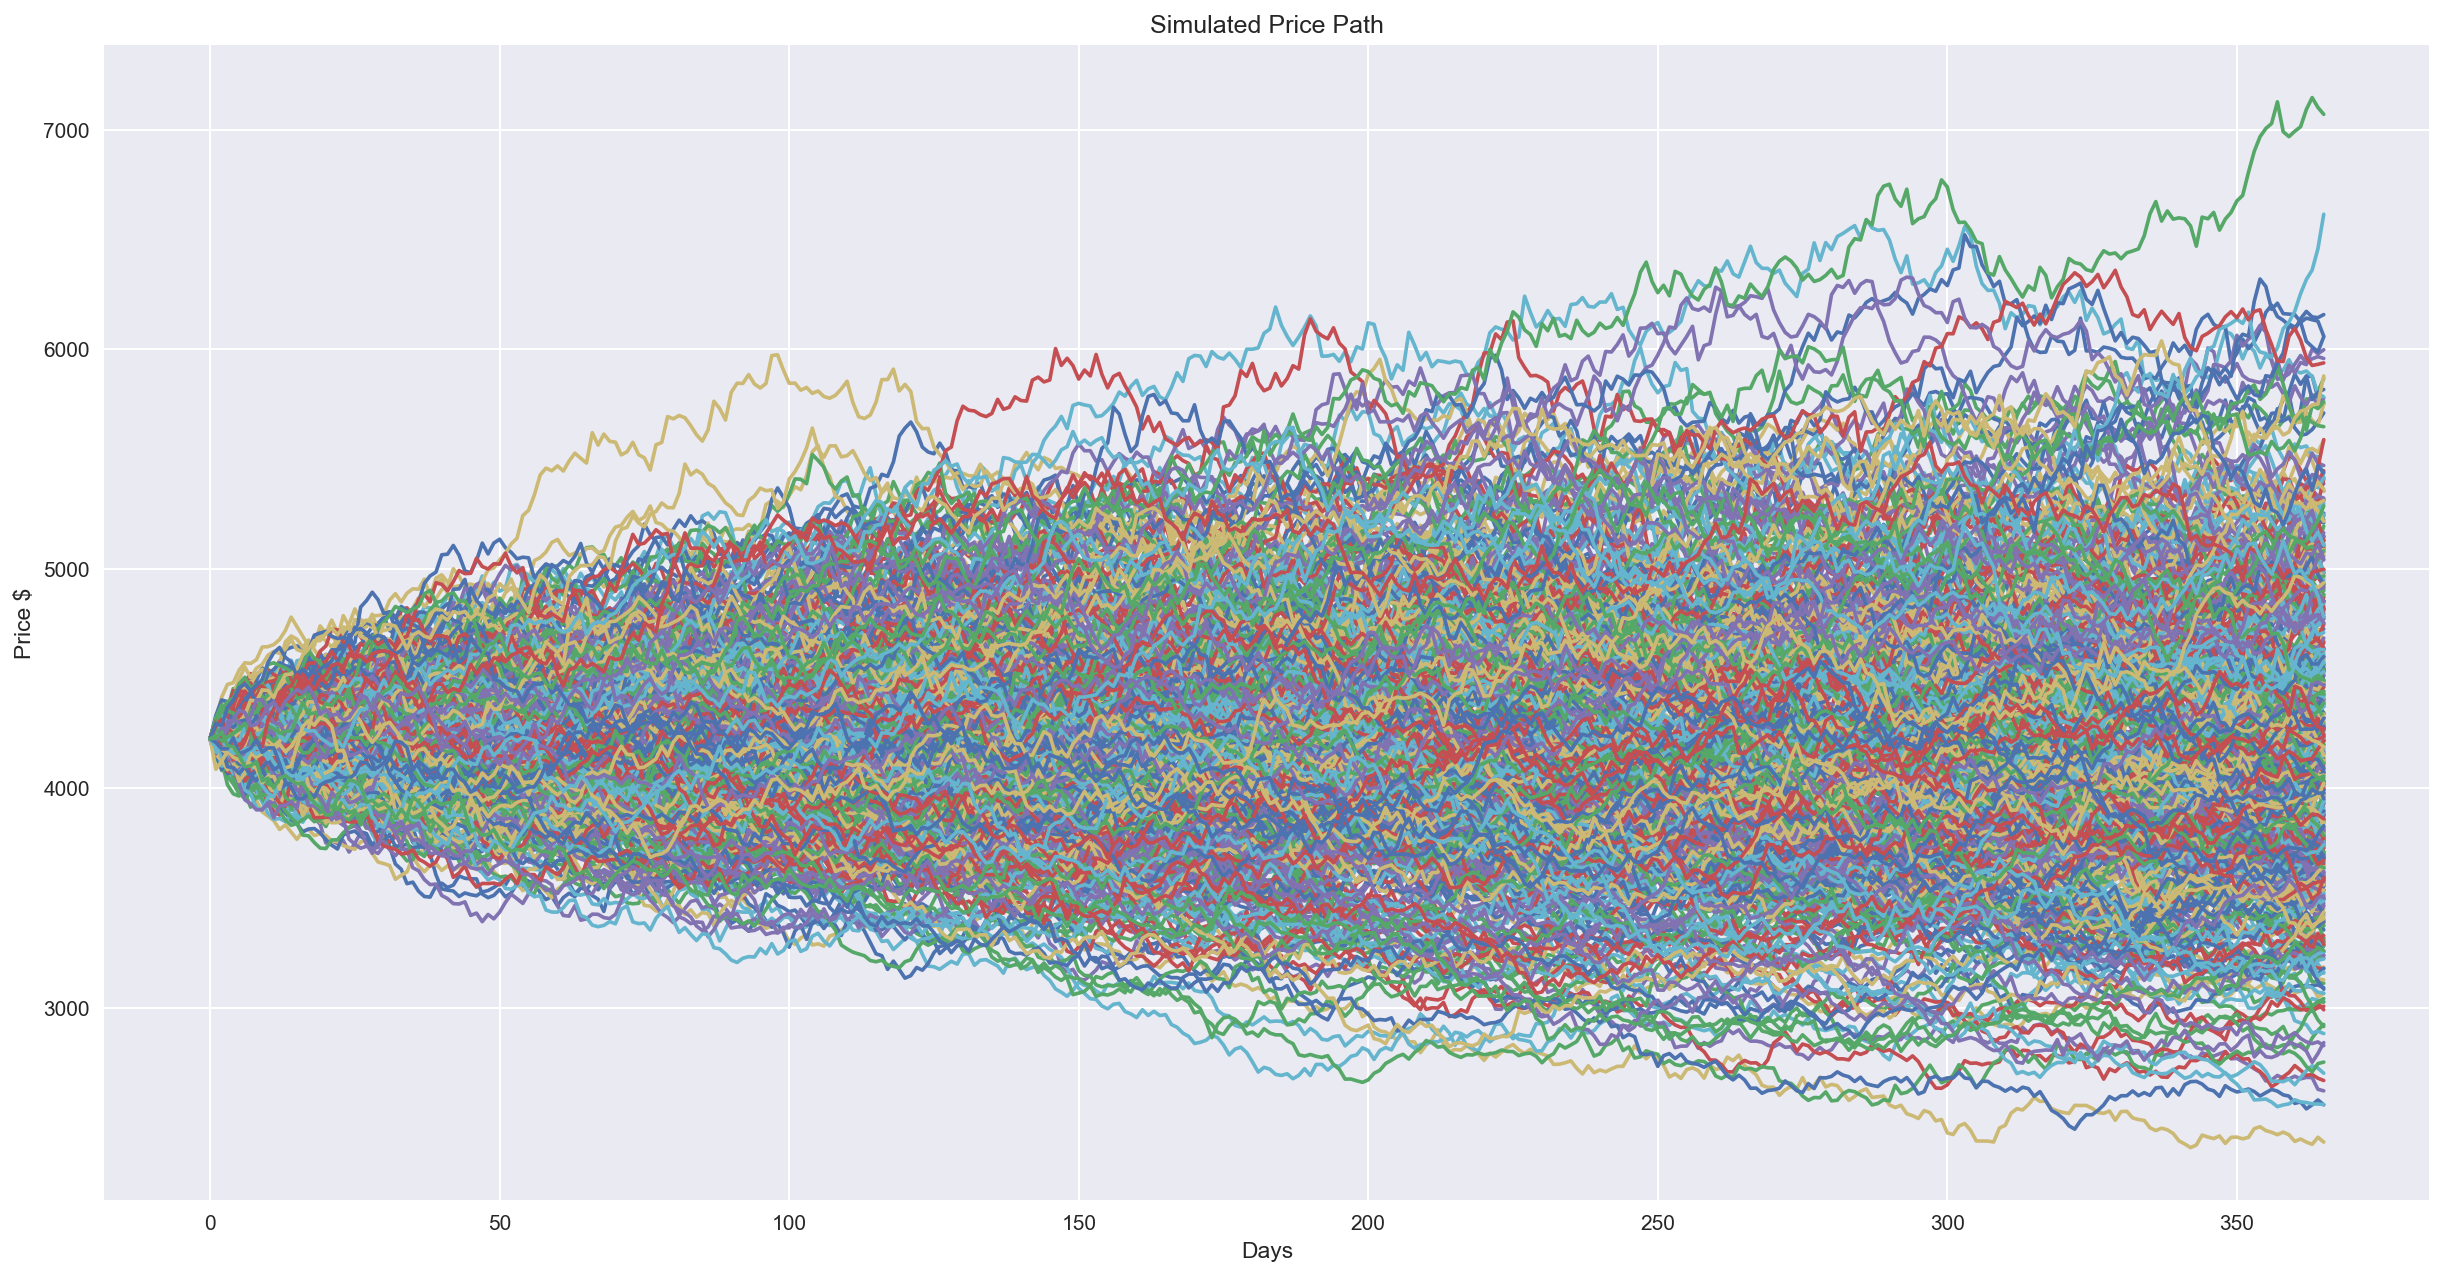

In [341]:
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (20,10)
samp = prices[np.random.choice(prices.shape[0], 500, replace=False), :]
plt.subplot(1,1,1)
plt.plot(samp.T)
plt.title('Simulated Price Path')
plt.xlabel('Days')
plt.ylabel('Price $')
plt.show()


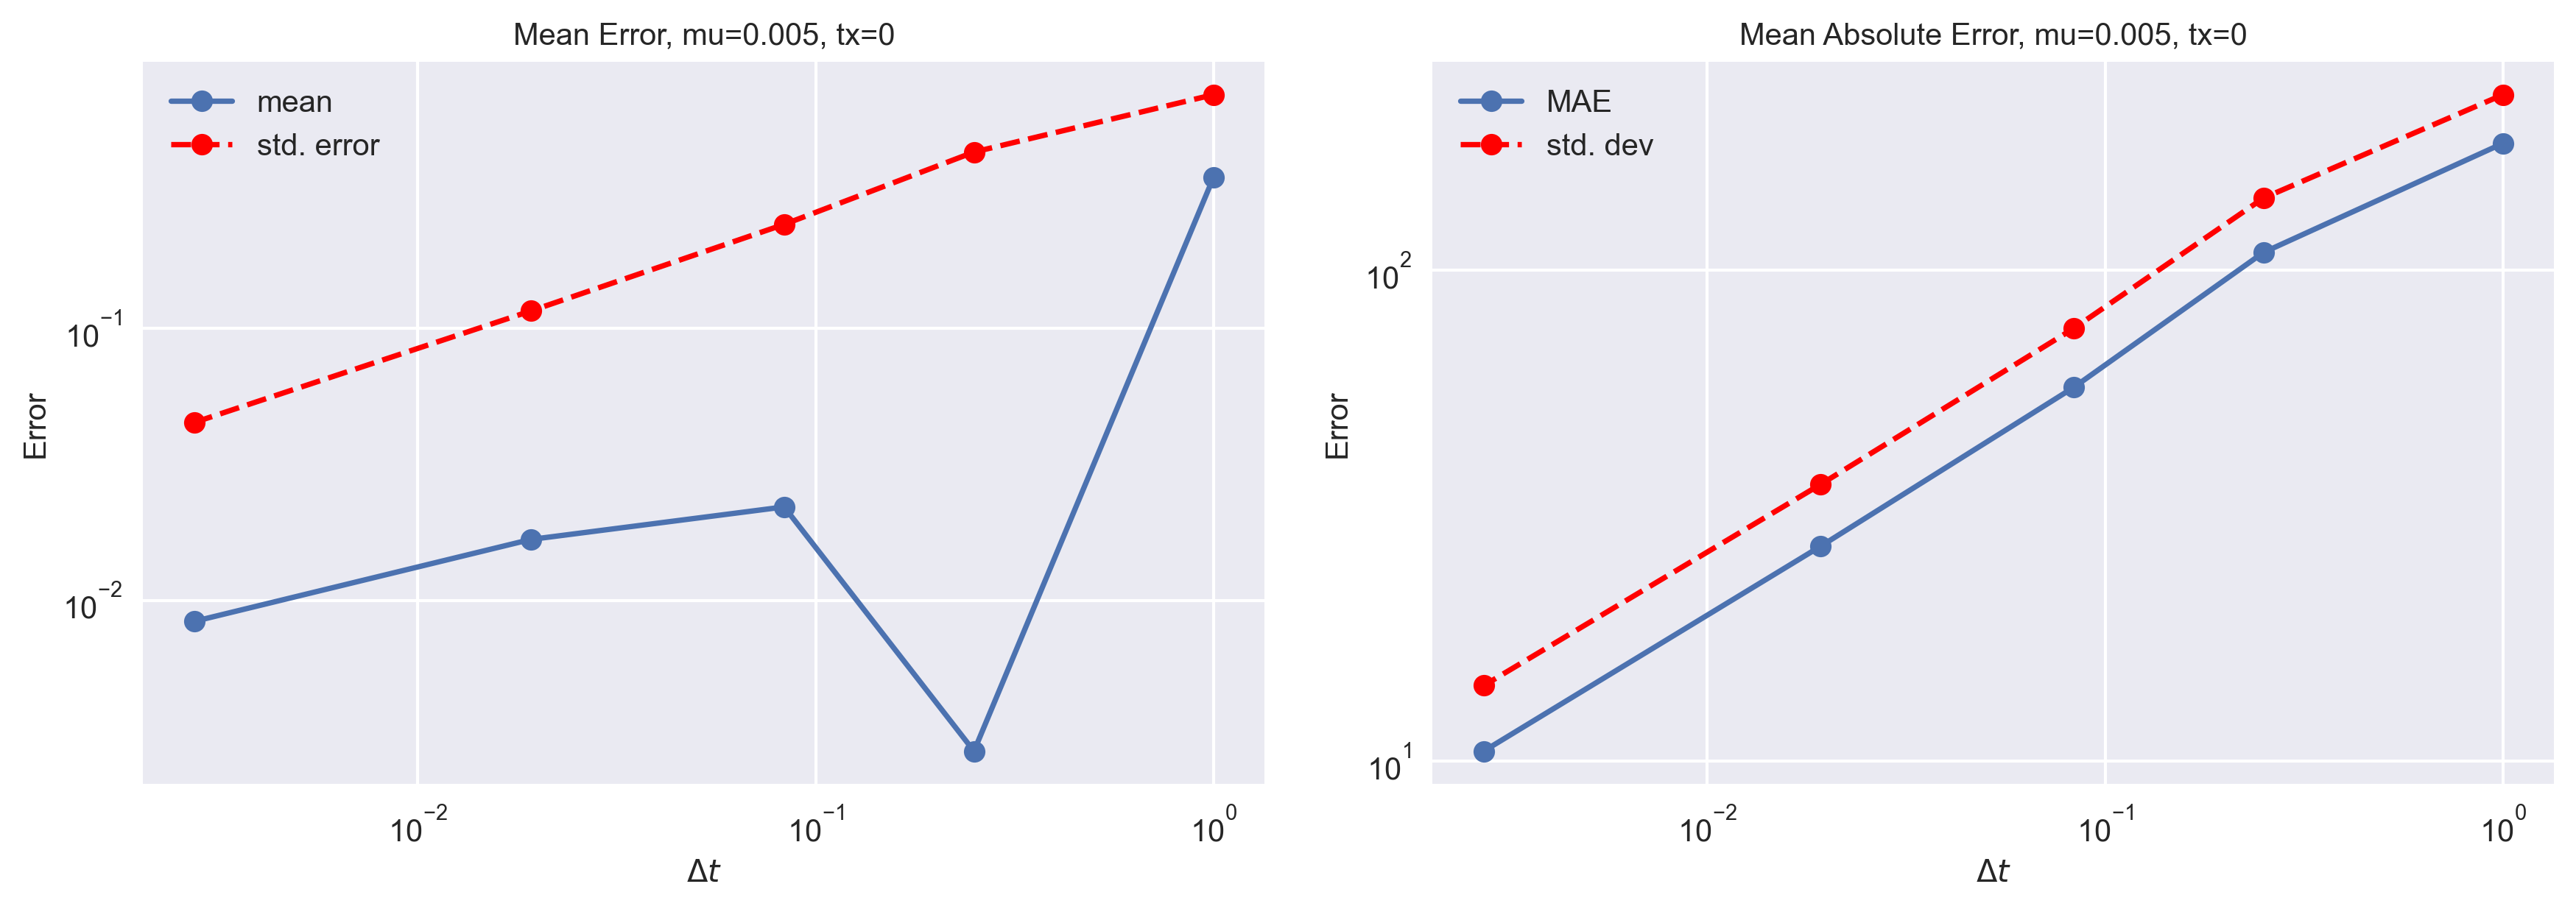

In [448]:
plot_stats(np.array(hedge_periods),res, 'hedge_periods', mu=dh.r)

## Error P-Value

In [478]:
dh.r=0.1
p_prices = simulate(n, r, hedge_periods, dh)[1]

In [529]:
error = pd.DataFrame((p_prices - p_val).mean(axis=1), columns=['Mean $\mathcal{E}$'], index=hedge_periods)
error['P-value'] = norm.cdf(error.iloc[:, 0])*2
error['P-value'].astype(float)
error['Significant'] = error['P-value'] <= 0.05
error

Mean $\mathcal{E}$       P-value  Significant
0           -266.083949  0.000000e+00         True
1            -43.918736  0.000000e+00         True
4            -13.779125  3.403720e-43         True
12            -3.513509  4.422292e-04         True
52            -0.949564  3.423338e-01        False
365           -0.183927  8.540704e-01        False

## 1.b Varying Mu

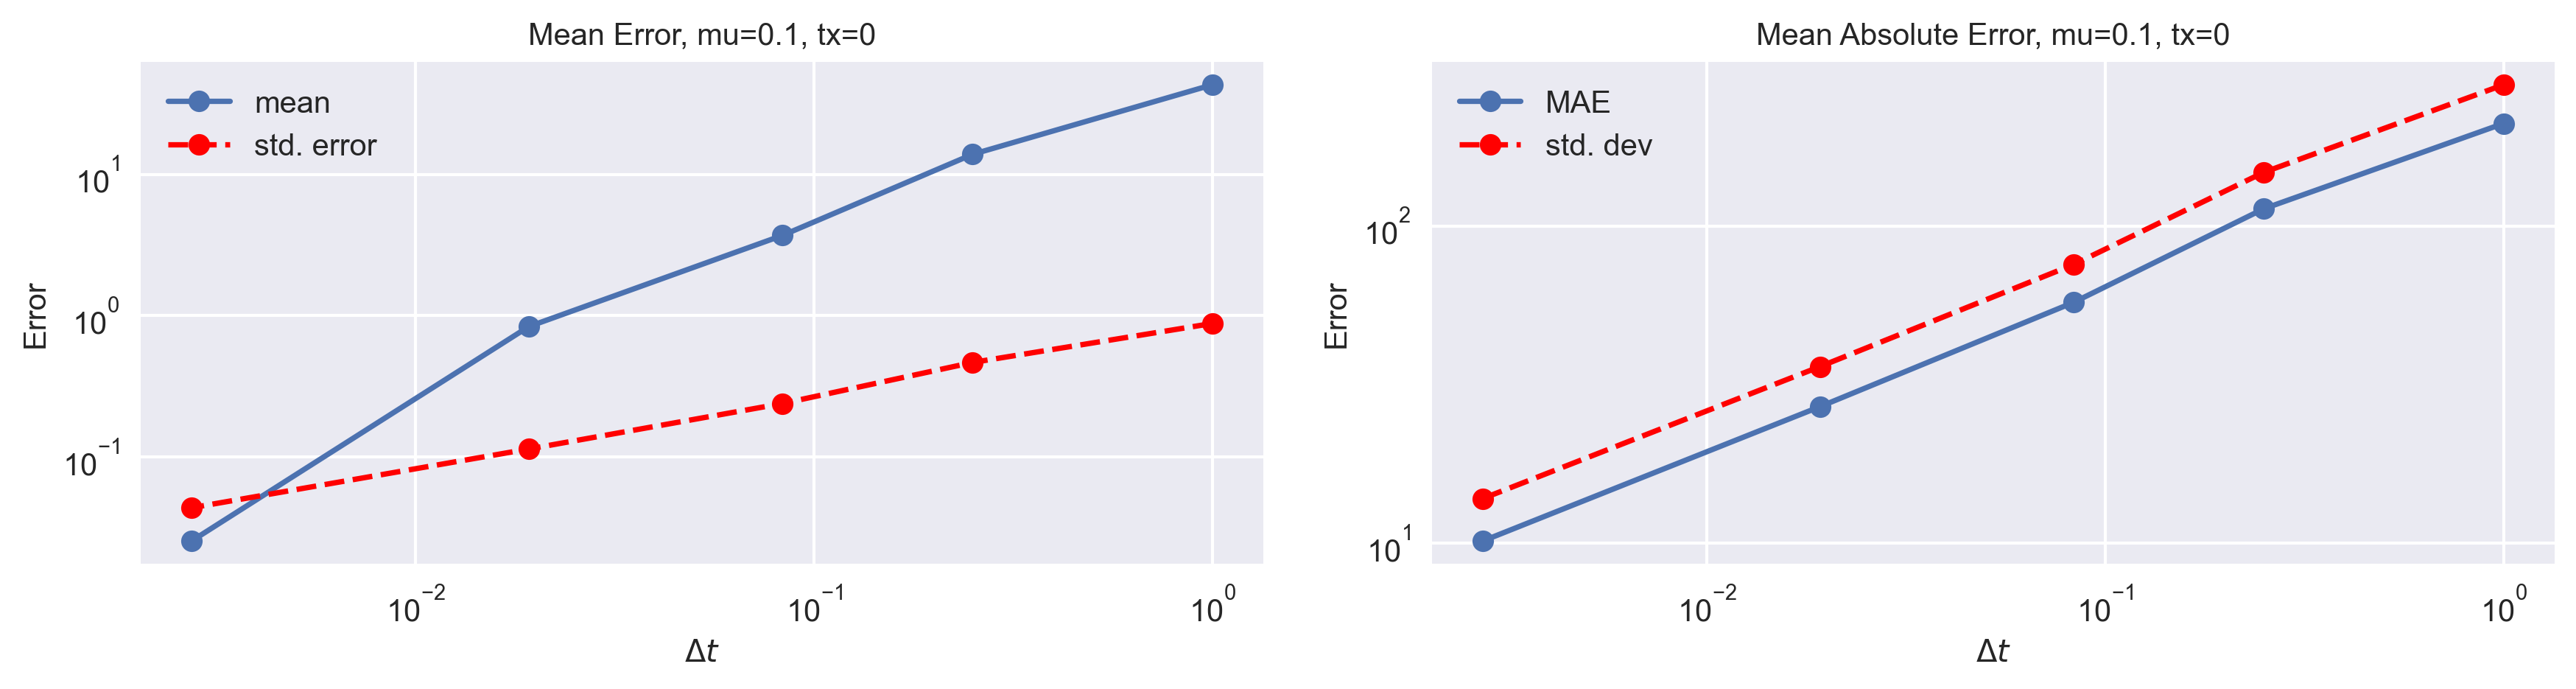

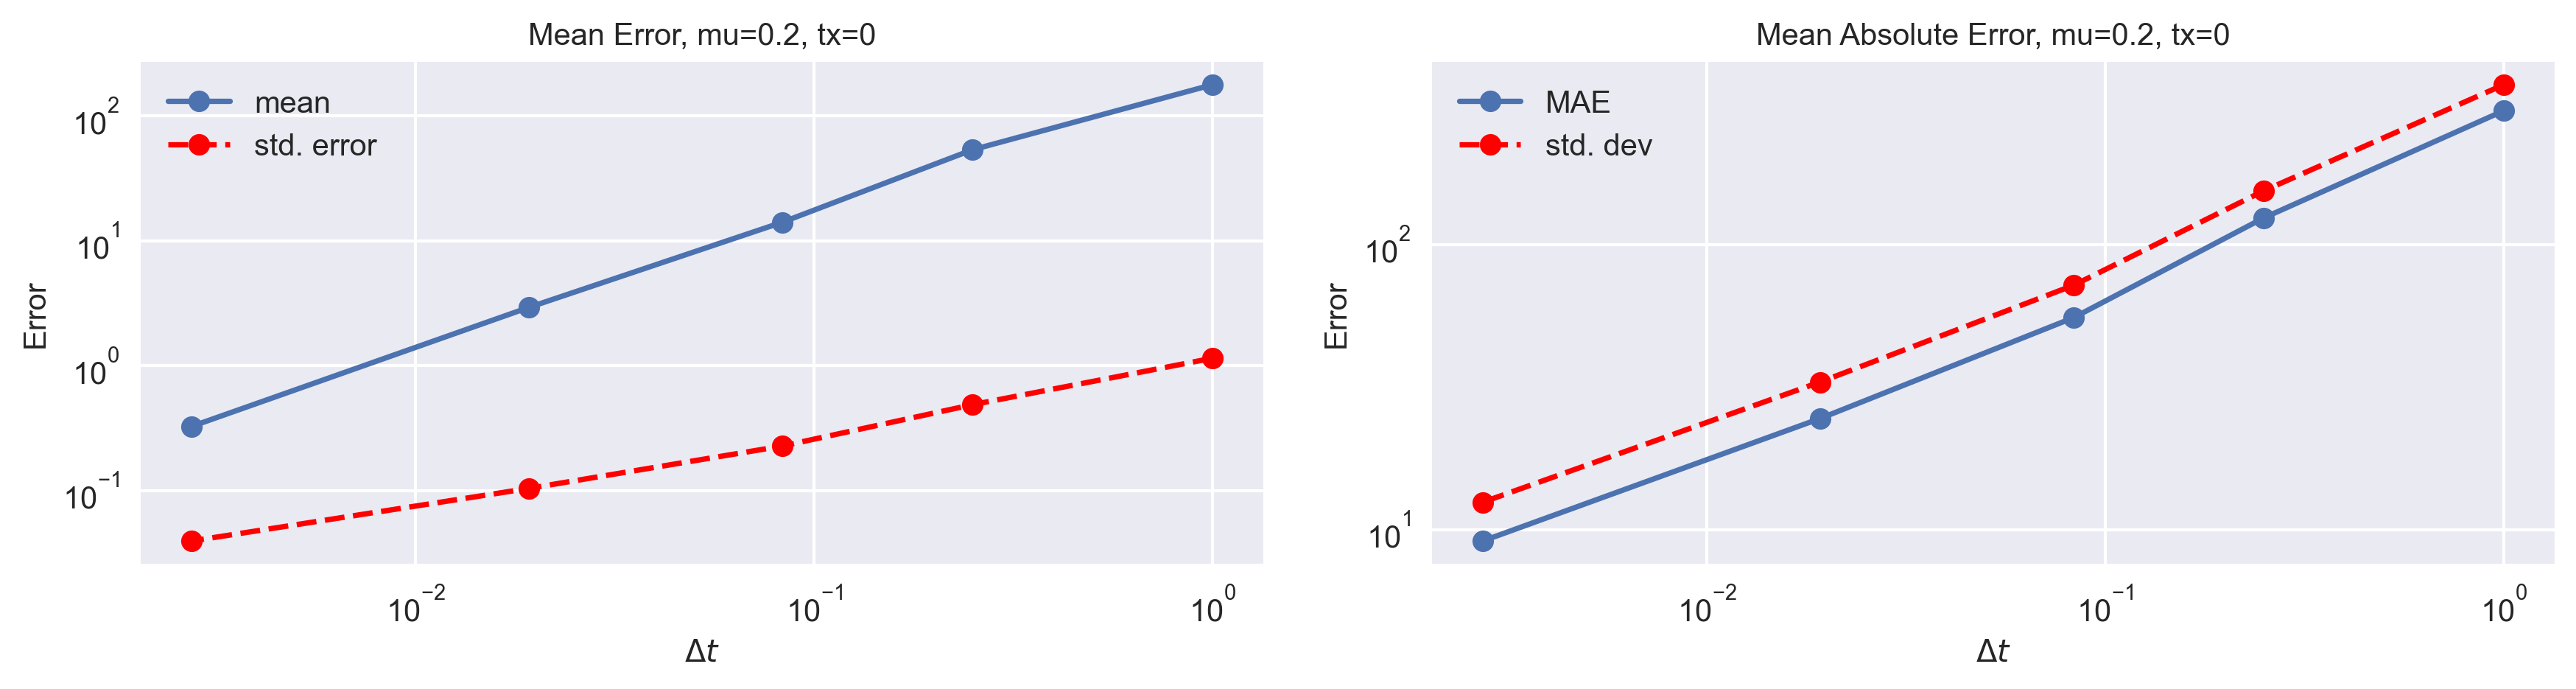

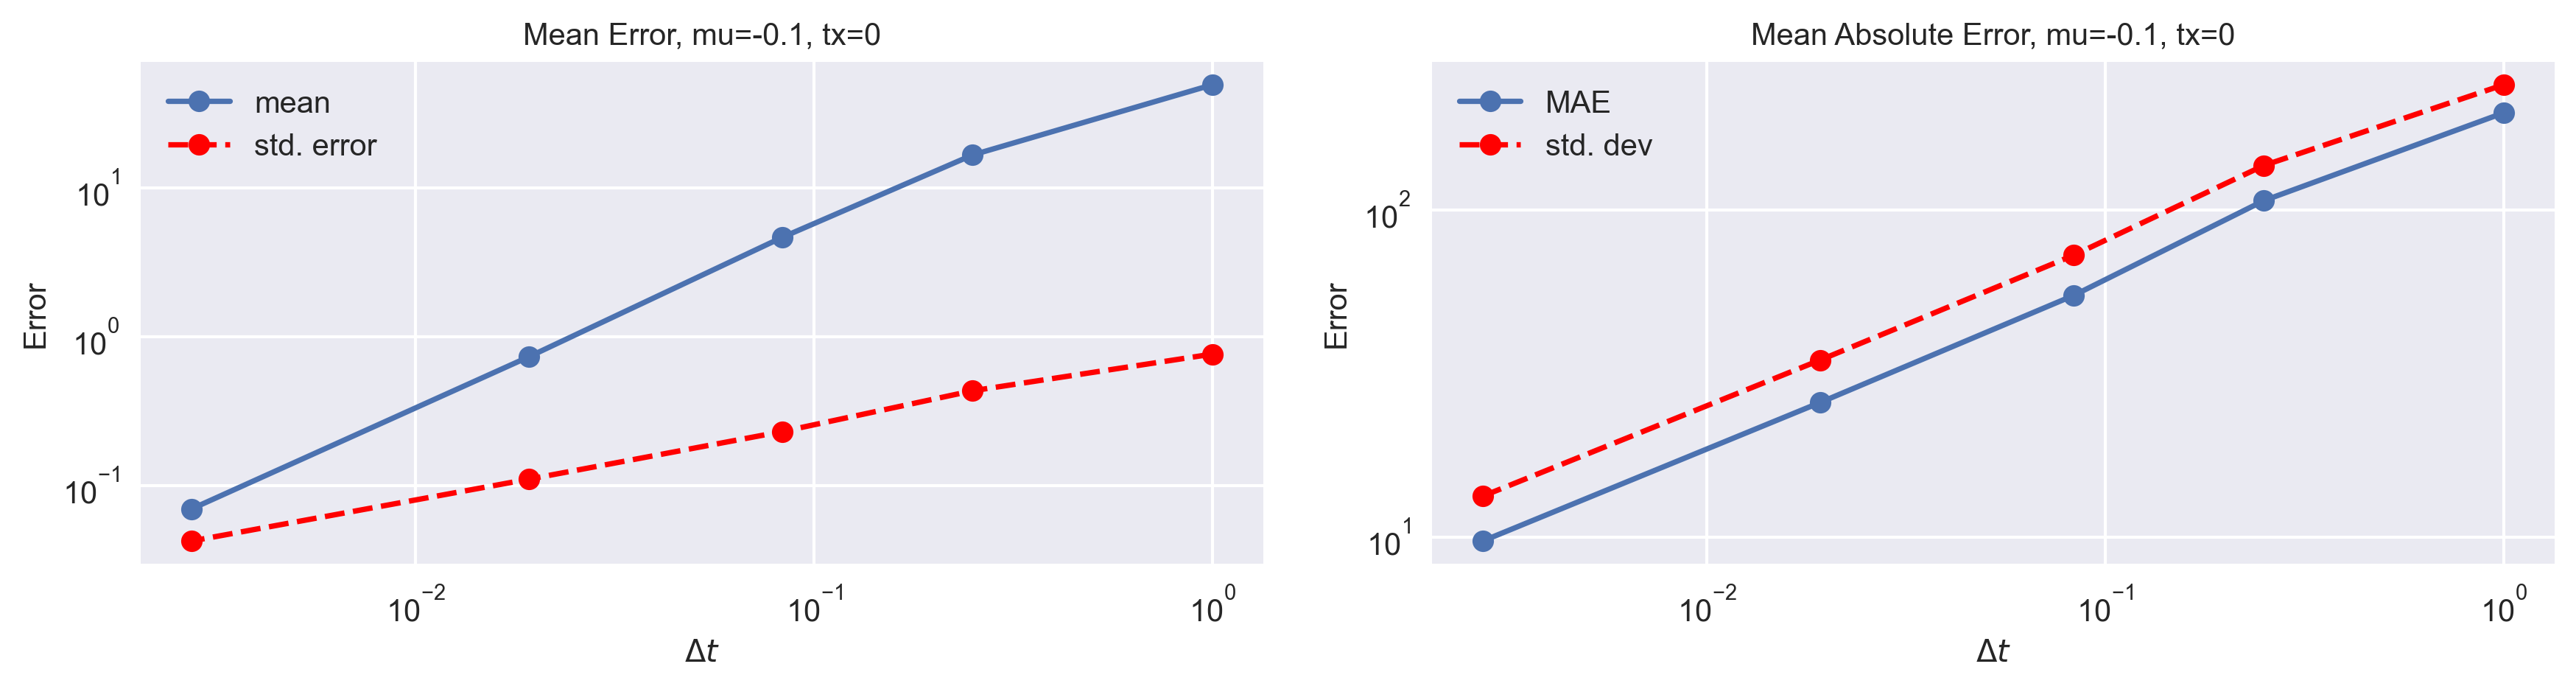

In [426]:
mu = [0.1,0.2,-0.1]
res_mu = []
for u in mu:
    dh.r = u
    res_mu.append(simulate(n, r, hedge_periods, dh))
    plot_stats(np.array(hedge_periods),res_mu[-1], f'var_mu{u}',mu=u)

## 1.c Adding Transaction Costs

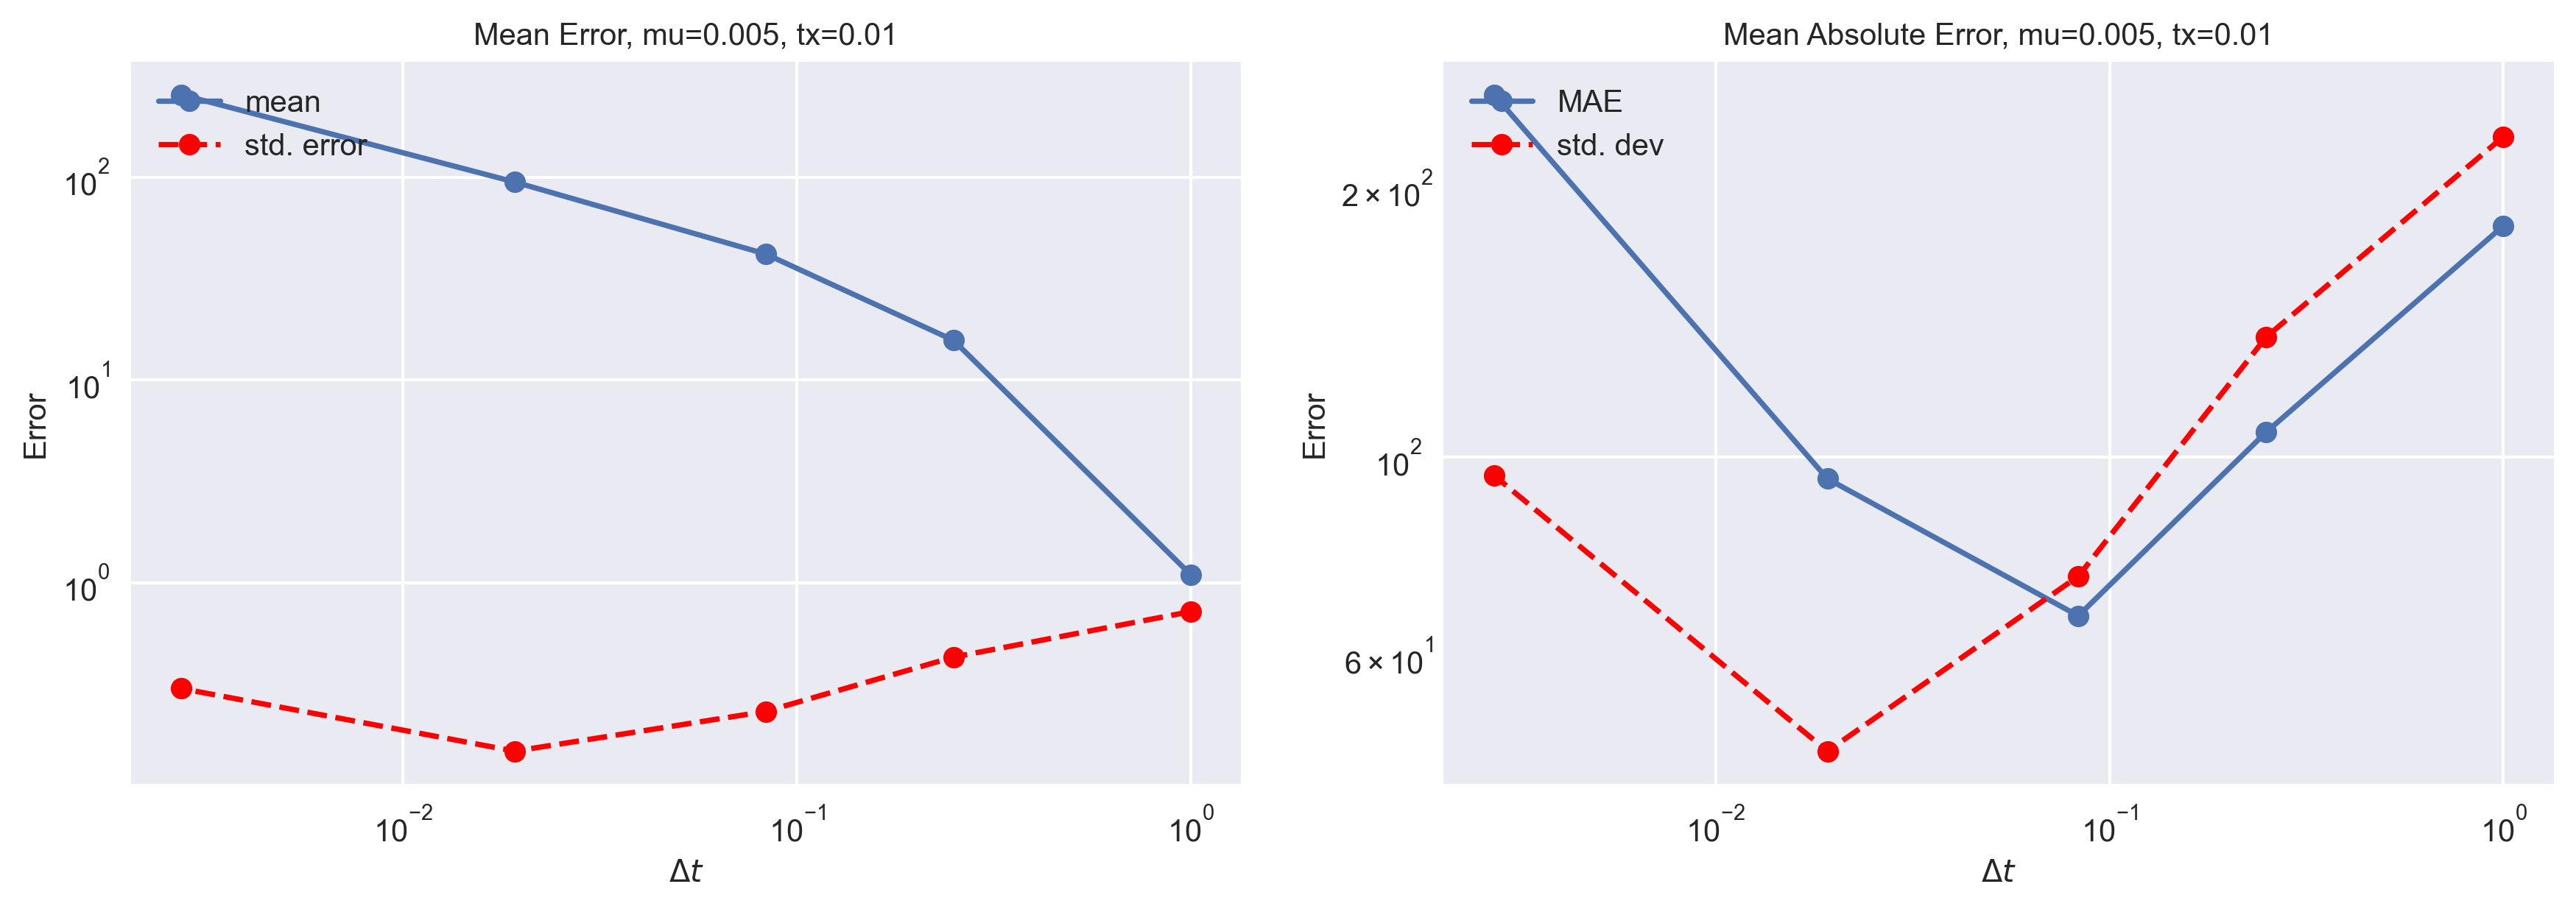

In [454]:
dh.r = 0.005
tx_simulation = simulate(n, r, hedge_periods,  dh, TX=0.01)
plot_stats(np.array(hedge_periods),tx_simulation, 'tx_sim',mu=dh.r, tx=0.01)

In [530]:
tx_simulation

mean  mean_absoulte  standard_deviation  standard_error
0      2.928141     380.139610          504.951023        1.596795
1      0.358113     181.479375          227.994974        0.720983
4     16.707683     107.316795          136.552176        0.431816
12    41.545901      66.186079           73.067922        0.231061
52    94.510712      94.667637           46.670061        0.147584
365  254.691951     254.691951           95.956019        0.303440